# Create a counterfeit banknote detection algorithm based on Logistic Regression
# Project 6  - Exploratory Data Analysis

## Get started

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns

%matplotlib inline

In [10]:
df = pd.read_csv(Path.cwd()/'notes.csv')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


The dataset is labelled and contains the following information:

- The length of the ticket (in mm);
- The height of the ticket (measured on the left side, in mm);
- The height of the ticket (measured on the right side, in mm);
- The margin between the top edge of the banknote and the image thereof (in mm);
- The margin between the lower edge of the banknote and the image thereof (in mm);
- The diagonal of the banknote (in mm).
- label column type boolean

## Data Description

Let's start by having a look on the structure of the dataset and the global quality.

In [11]:
df.shape

(170, 7)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [13]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [14]:
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Nothing looks odd: none missing values, none atypical values or negative (errors). The data format looks good.

In [15]:
# How many individuals do we have for each category?
df.groupby('is_genuine').count().iloc[:,0]

is_genuine
False     70
True     100
Name: diagonal, dtype: int64

The dataset is slightly imbalanced: we have 30 more individuals in the "genuine" set than in the "fake" set.

## Univariate Analysis

### Distribution

In [16]:
tmp = df.iloc[:,1:] # we remove the boolean column for the distribution plot

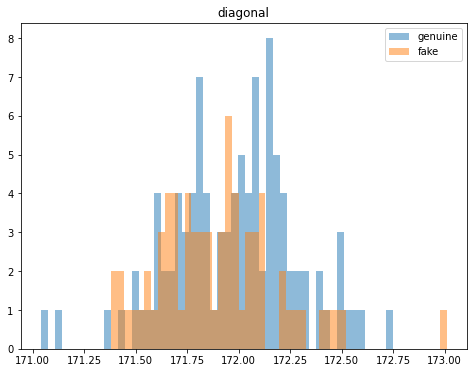

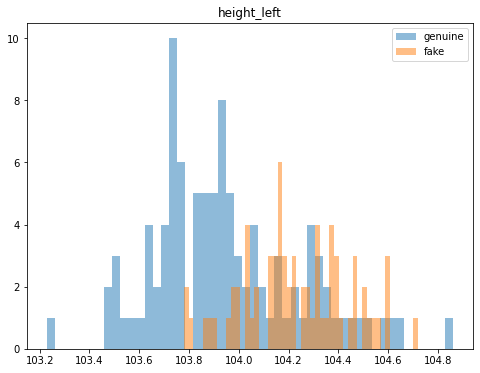

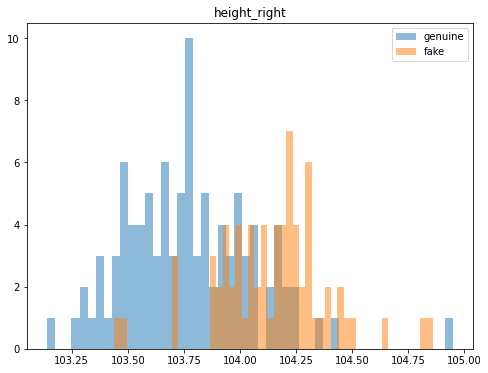

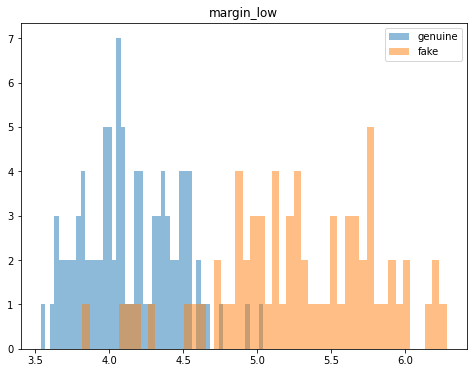

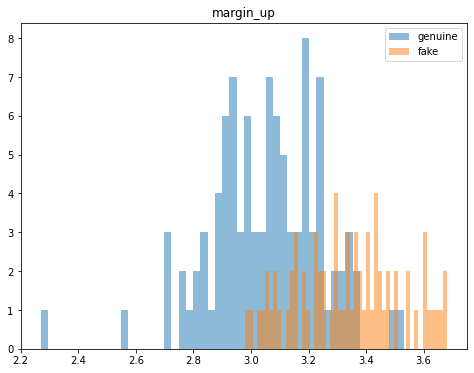

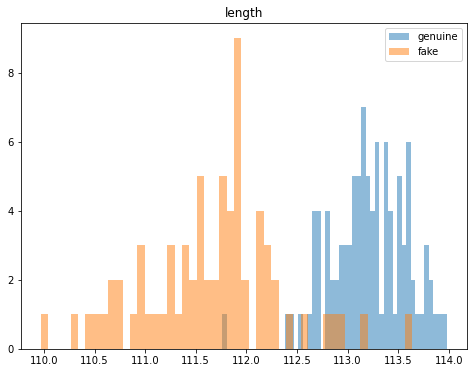

In [17]:
# Check the Distribution for each columns
for i in tmp.columns:
    plt.figure(figsize=(8,6))
    tmp1 = df[df['is_genuine'] == True]
    tmp2 = df[df['is_genuine'] == False]
    plt.hist(tmp1[i], bins=50, alpha=0.5, label="genuine")
    plt.hist(tmp2[i], bins=50, alpha=0.5, label="fake")
    plt.title(i)
    plt.legend(loc='upper right')

We can see that the distributions for each variables look slightly different, whether or not, the banknote is genuine. 
In particular, for:
- length, 
- margin_up/low 
- and height_left/right
However, the distributions of the 2 categories for the feature diagonal are overlapping, which might indicates that this feature is not relevant to separate the genuine and the fake banknotes. 

All in all, each features seem to be normally distributed with a positive and/or a negative skewness. Let's use the boxplots to see whether or not these values can be considered as outliers. </div>

### Box-plots

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


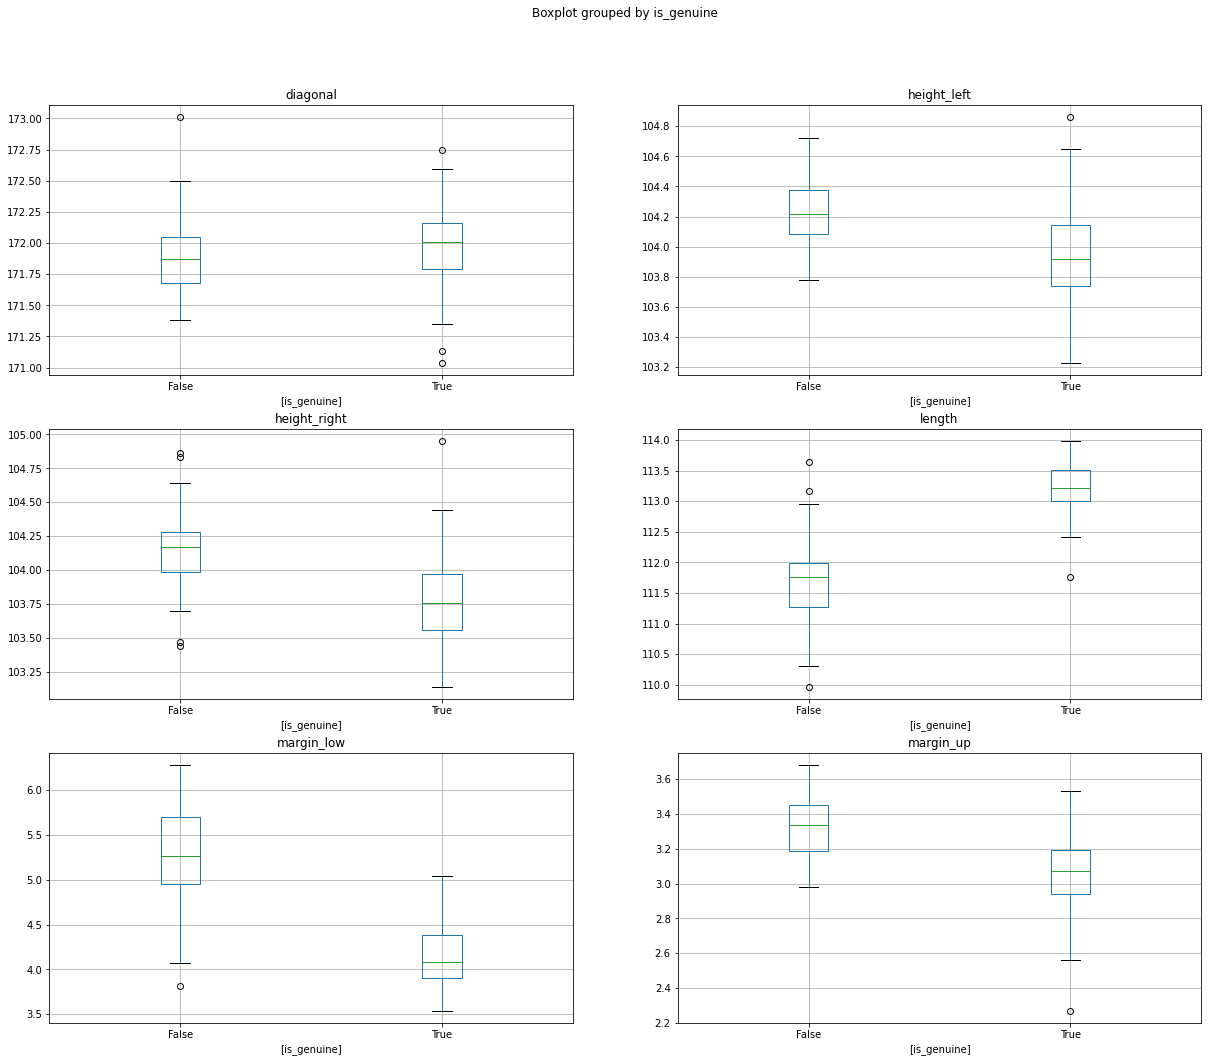

In [18]:
# Create boxplots to visualize the potential outliers
fig, ax_new = plt.subplots(3,2, sharey=False,figsize=(20,17))
df.boxplot(by="is_genuine",ax=ax_new)
plt.show()

We can detect some outliers (extreme values) in both categories. It might be interesting to investigate further on this data points and see whether or not, we keep them in the dataset.

### Outliers

Often, machine learning modeling can be improved by understanding, handling or removing the outlier values.
 
- One method for removing the outliers when the data are following a Gaussian-like distribution, consist of using a threshold = 3 Standard Deviation. A value that falls outside of 3 standard deviations from the mean is part of the distribution, but it is an unlikely or rare event. This is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used. 

- Another method if the data are not normal or not normal enough to treat it as being drawn from a Gaussian distribution, consist of using the InterQuartile Range (IQR). The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots. 
    - On the previous box-plots, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.
    
Source: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
    
Let's explore now the outliers we just visualized on the box-plots.

In [19]:
# Identify the outliers for each features in both categories
def get_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)] 
    
    return df_out

In [20]:
# Apply the function at labels level
df.groupby('is_genuine').apply(get_outliers).reset_index(drop=True)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,172.32,104.60,104.83,4.84,3.51,112.55
1,False,171.83,104.39,104.17,5.51,3.33,113.64
2,False,172.29,104.72,104.86,5.71,3.16,112.15
3,False,171.74,103.96,103.47,5.14,3.30,111.40
4,False,171.95,104.47,104.34,5.92,3.10,113.17
5,False,171.68,103.89,103.70,5.97,3.03,109.97
6,False,171.67,103.79,103.44,5.13,3.32,111.47
7,False,172.50,104.07,103.71,3.82,3.63,110.74
8,False,173.01,104.59,104.31,5.04,3.05,110.91
9,True,171.81,104.86,104.95,4.52,2.89,112.83


We count 14 outliers in total:
- 9 for the fake banknotes
- 6 for the genuine banknotes
    
The questions now are: 
- Can they affect the accuracy of the detection algorithm?
- Are they due to a measurement error or data entry error?  
- Are they (or not) a normal part of the population? 
    
Having outliers on the fake banknotes is something we could expect as by definition these banknotes are not genuine so not standardized. To the question: "Are they a normal part of the population?" we could answer: most likely. 
To the contrary, having outliers on the genuine banknotes is not normal. Banknotes are supposed to follow a rigourous standard in terms of dimensions, so to the question: "Are they a normal part of the population?" we could answer: no. They could be due to a measurement error or a data entry error. 

- Considering this, we suggest to keep the outliers on the fake set and remove them from the genuine set. This will rebalance a bit the dataset. 
- To measure the impact of the outliers in the "genuine" set, we decide to perform the analysis on 2 datasets: with and without the outliers. We will discuss at the end, the results and effects on the model's accuracy. 


In [22]:
# Remove the outliers for each features when banknotes are genuine
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df2 = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df2

In [25]:
df2 = remove_outliers(df[df['is_genuine'] == True]).append(df[df['is_genuine'] == False])
df2.shape

(164, 7)

/Users/aureliegiraud/.virtualenvs/env3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


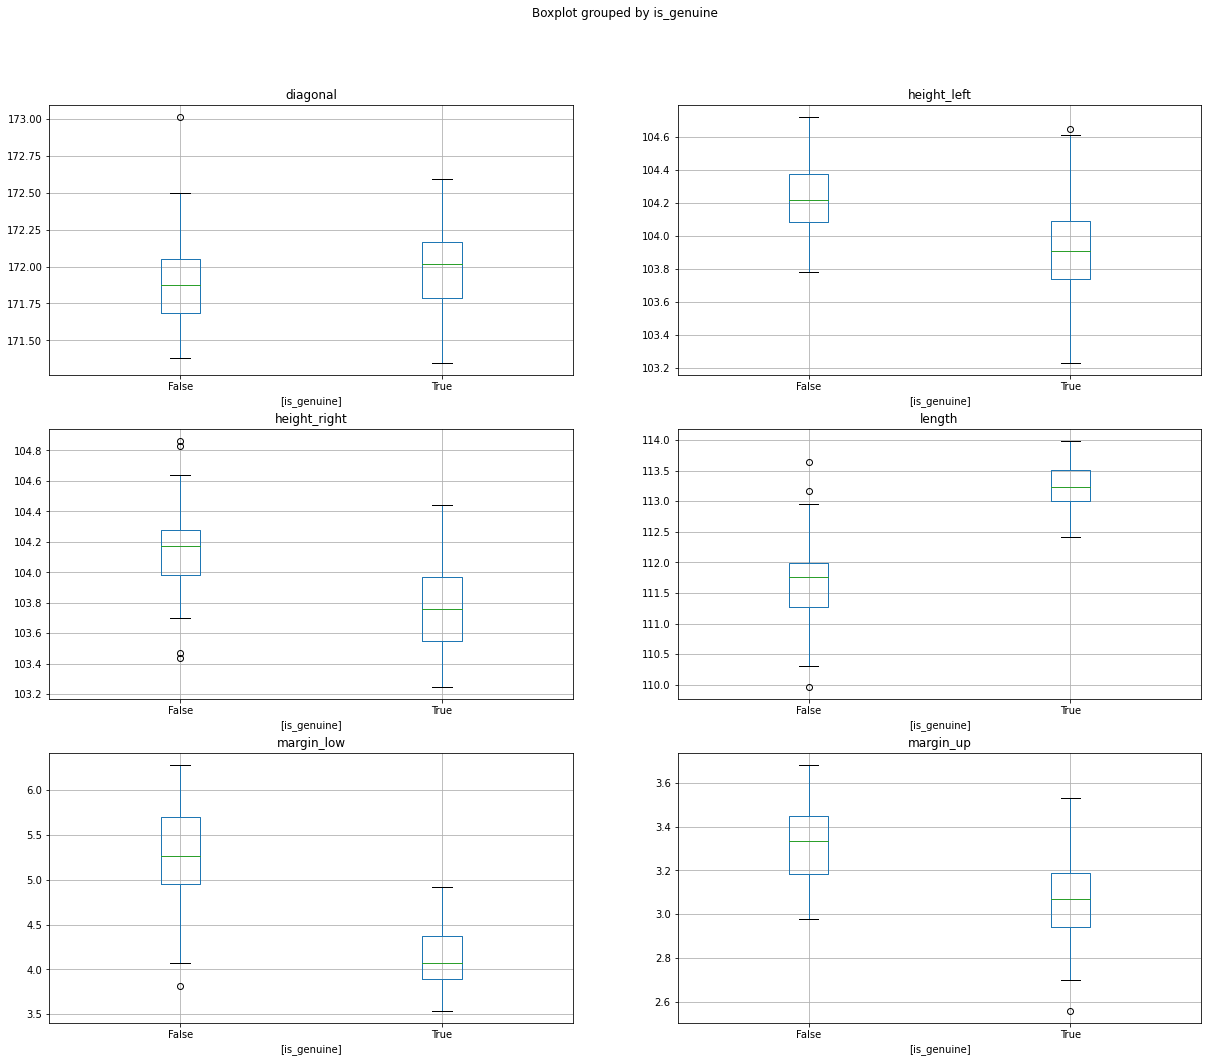

In [24]:
# Checking the effect of the cleaning
fig, ax_new = plt.subplots(3,2, sharey=False,figsize=(20,17))
df2.boxplot(by="is_genuine",ax=ax_new)
plt.show()

We removed the main outliers. Some outliers are remaining as they are very close to the Q3, for this reason we decide to keep them.
We have now 2 datasets:

- df = with outliers
- df2 = without outliers

## Bivariate Analysis

In the previous part, we visualized the structure and distribution within a single column. 
In this part, we'll expand the exploration by visualizing the relationships between two variables at a time to understand:
- How variables interact with one another?
- Does an increase in one variable correlate with an increase/decrease in another? 

In [27]:
# Drop the boolean column (labels) from the analysis
tmp = df.iloc[:,1:] 
tmp2 = df2.iloc[:,1:] 

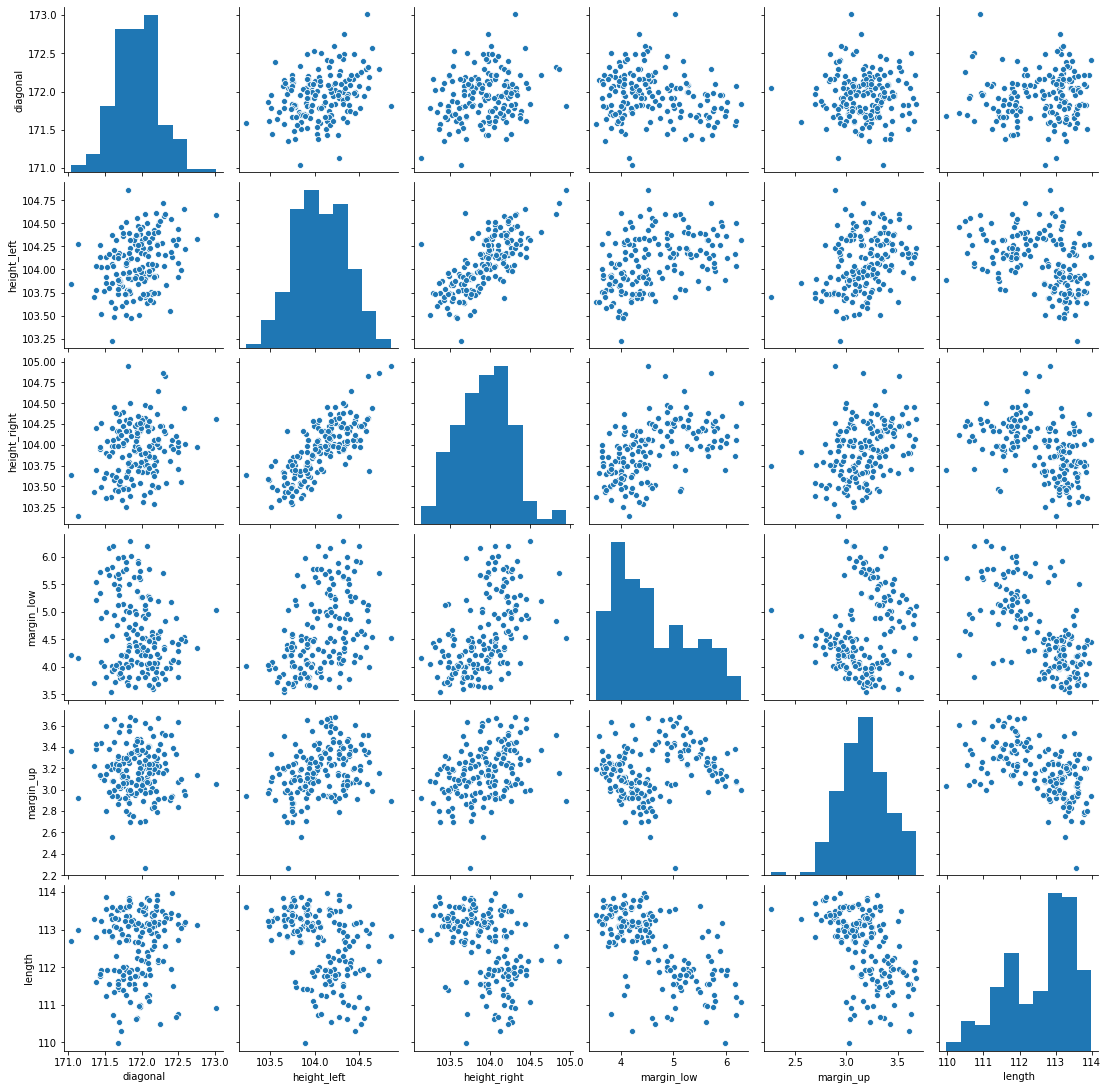

In [28]:
# We can visualize the correlation & distribution of the variables with Seaborn Pairplot
# on the dataset with outliers
sns.pairplot(tmp)

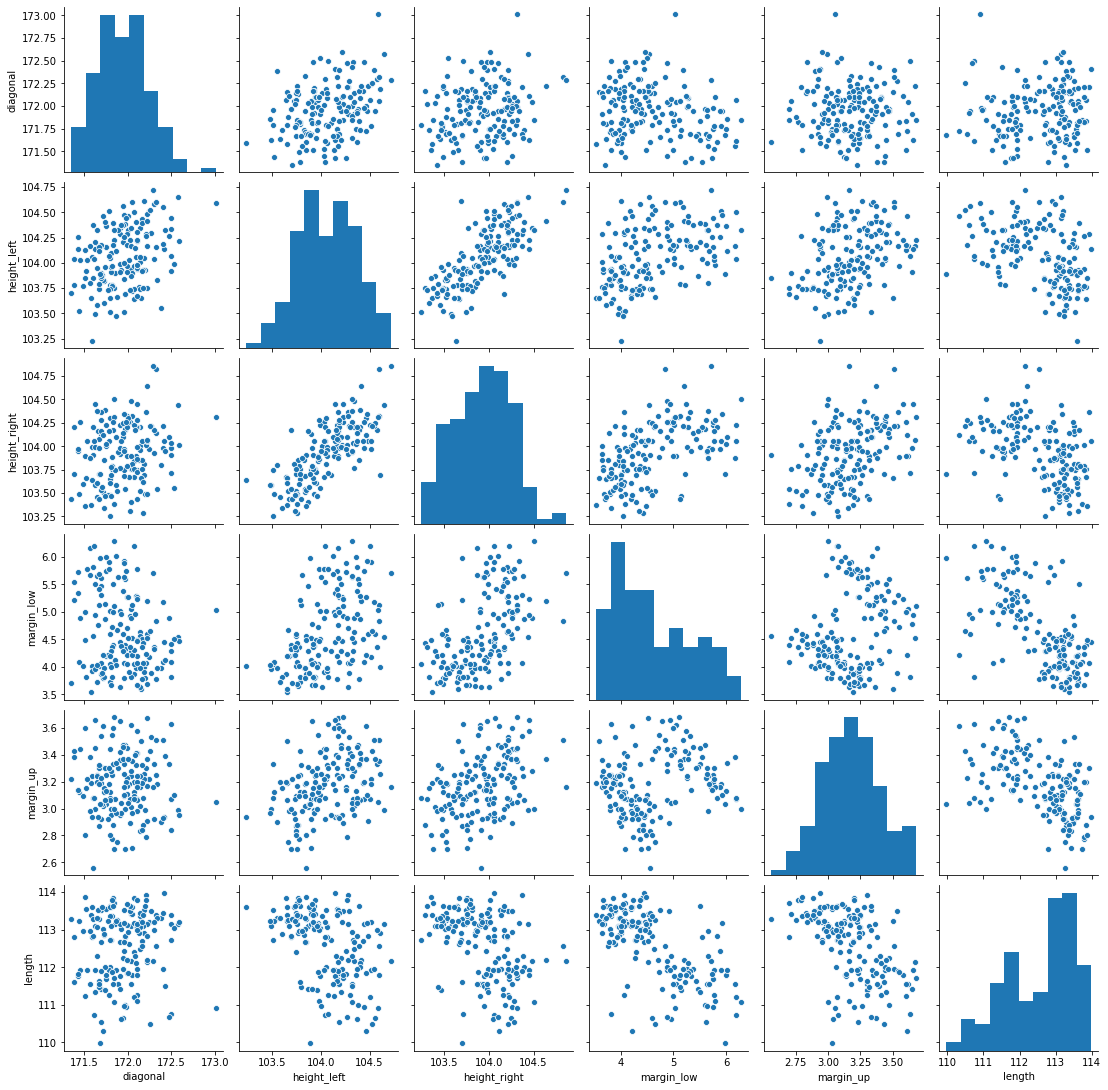

In [29]:
# We can visualize the correlation & distribution of the variables with Seaborn Pairplot
# without outliers
sns.pairplot(tmp2)

We can make the following observations on both dataset:

- height_left & height_right:
    - seem to be correlated to each other
    - seem to be positively correlated with margin_up and margin_low 
    - seem to be negatively correlated to length.
    
    
- margin_low & margin_up:
    - seem to be negatively correlated to length
    - seem to be positively correlated with height (both left and right)
    - seem not to be correlated to each other
    
- diagonal:
    - seem not correlated to any other feature
    
These observations are relevant and might be visible likewise with the PCA. Let's check them on the correlation matrix.

<AxesSubplot:>

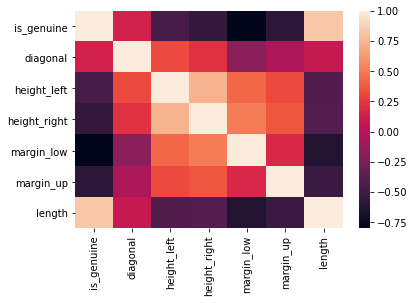

In [31]:
# Heatmap of correlation matrix
sns.heatmap(df.corr()) # With outliers

<AxesSubplot:>

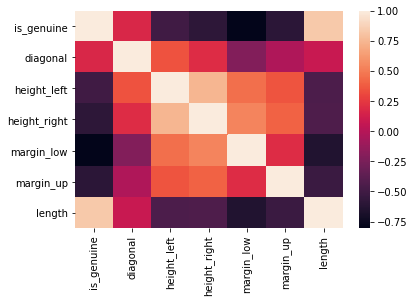

In [32]:
# Without outliers
sns.heatmap(df2.corr())

All the previous observations based on the pairplots are visible and verified on the correlation matrix.
Furthermore, we can see that the coefficient of correlation between the feature diagonal and the label column "is_genuine" is very low. 
It indicates (again), that the variable diagonal is not relevant to find out if a banknote is genuine or not.

- We decide to drop this feature before to move to the next step: Dimensionnality reduction with PCA.

In [33]:
# Drop the feature diagonal
df = df.drop(['diagonal'],axis=1)
df2 = df2.drop(['diagonal'],axis=1)

In [35]:
# Export the output for the next step (PCA)
df2.to_csv(Path.cwd()/'dataset_cleaned.csv')
df.to_csv(Path.cwd()/'dataset.csv')